This is my first attempt to solve the Spaceship Titanic Data science competition on the data science platform Kaggle.

# Preliminary: imports and load the data

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os
sns.set_theme(style="darkgrid")

In [153]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

Please make sure to download the data and have it in the same directory as this notebook when running it.

In [154]:
import os
from zipfile import ZipFile

DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "spaceship-titanic.zip"
file_name_no_zip = "spaceship-titanic"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [155]:
train_loc = os.path.join(os.getcwd(), "train.csv")
test_loc = os.path.join(os.getcwd(), "test.csv")

df = pd.read_csv(train_loc)
df_test = pd.read_csv(test_loc)

# Helper functions
in this subsection I write a number of functions to frequently use later.

In [156]:
# a function to delete columnsfrom both the train and test datasets
def drop_cols(cols, df_train: pd.DataFrame, df_test: pd.DataFrame):
    if isinstance(cols, str):
        df1 = df_train.drop(cols, axis=1)
        df2 = df_test.drop(cols, axis=1)
    else:
        df1 = df_train.drop(columns=cols)
        df2 = df_test.drop(columns=cols)
    return df1, df2

In [157]:
def new_col_names(old_new_names, df_train ,df_test):
    try:    
        df = df_train.rename(columns=old_new_names)
        df_test = df_test.rename(columns=old_new_names)
        return df, df_test
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        df_test_no_col = [col for col in old_new_names.keys if col not in df_test.columns]
        print("{cols} are not in the {dataf}".format(df_no_col, "training dataset"))
        print("{cols} are not in the {dataf}".format(df_test_no_col, "test dataset"))


In [158]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(df: pd.DataFrame, features_names: list=None):
    # select all categorical features if none of them were specified
    if features_names is None:
        features_names = df.select_dtypes(include=['object']).columns.tolist()
    # define the encoder
    
    ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False, dtype=np.int64)
    for f in features_names:        
        try:
            unique_values = np.unique(df[f])
        except:
            unique_values = list(df[f].value_counts().index)
        
        # if there is only one unique value in the column, then this column is to be dropped
        if len(unique_values) <= 1 :
            break
        # the names for the  newly-created features
        new_names = [f'{f}_{u}' for u in unique_values[1:]]
        new_values = ohe.fit_transform(df[[f]])
        print(ohe.categories_)
        df[new_names] = new_values
    
    return df


In [159]:
! pip install empiricaldist

In [160]:
from empiricaldist import Cdf

def display_cdf(data: pd.DataFrame, num_feat: str, cat_feat: str, feat_values: list=None):
    if feat_values is None:
        # extract the unique values in the passed feature
        feat_values = list(data[cat_feat].value_counts().index)
    
    # iterate through the different values of feat_values 
    for v in feat_values:
        d = data[data[cat_feat] == v][num_feat]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=f'{cat_feat} == {v}')

    plt.legend()
    plt.xlabel(f'{num_feat}')
    plt.ylabel(f'cdf of {num_feat}')
    plt.show()   
                

In [161]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    # find the number of nans in each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate the percentage of missing values in each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    # convert the results into a dataframe
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [162]:
# let' define a function that applies a function to either 
# the whole dataframe or certain columns on the dataframe

def apply_functions(df_train, df_val, funcs, col_names=None):
    # either have one function passed that should be applied to the whole dataframe
    # or have an equal number of columns and functions where each funtion will be applied to the corresponding column
    all_data = callable(funcs) and col_names is None
    col_funcs = True
    #  if the funcs argument is indeed a function, then the code below will raise an error 
    try:
        col_funcs = (all([callable(f) for f in funcs]) and len(funcs) == len(col_names))
    except:
        col_funcs = False
    
    assert all_data or col_funcs
        
    if col_names is None: # if the function is to be applied on the whole dataframe
        df = df_train.apply(funcs, axis=1)
        df_test = df_val.apply(funcs, axis=1)
    else:
        df = df_train.copy()
        df_test = df_val.copy()

        for col, f in zip(col_names, funcs):
            df[col] = df[col].apply(f)
            df_test[col] = df_test[col].apply(f)
            
    return df, df_test

In [163]:
def get_col_types(df: pd.DataFrame):
    # select all numerical features 
    num_cols = list(df.select_dtypes(np.number).columns)
    # any feature that is non-numerical is selected as categorical
    non_num_cols = [c for c in df.columns if c not in num_cols]
    num_cols = list(df.select_dtypes(np.number).columns)
    return num_cols, non_num_cols


In [164]:
def set_col_type(data:pd.DataFrame, column_type:dict):
    for c, type in column_type.items():
        data[c] = data[c].astype(type)
    return data


In [165]:
def display_histogram(data, num_feat, cat_feat, figsize=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = data.value_counts(cat_feat).values
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f'{cat_feat} == {v}')

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=10, num_cat='box', num_num='scatter'):

    try:
        data[feature]
    except KeyError:
        print(f"{feature} is not part of the dataframe's features")
        return 

    assert num_cat in ['box', 'cdf', 'hist']
    assert num_num in ['scatter', 'line']

    if use_cols is None:
        use_cols = data.columns

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    # first determine which columns are numerical and which are categorical
    num_feats, cat_feats = get_col_types(data)
    # convert the data into sets
    num_feats = set(num_feats)
    cat_feats = set(cat_feats)
    # consider the discrete features as categorical
    for n in num_feats:
        if len(data.value_counts(n)) <= nunique_as_discrete:
            # consider the numerical feature as categorical
            cat_feats.add(n)
    # remove every element in num_feats that belongs to cat_feats as well
    num_feats = num_feats.difference(cat_feats)

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col == feature: continue

            if col in num_feats:
                if num_cat == 'box':
                    sns.boxplot(data=data, x=col, y=feature, orient='h')
                    plt.show()
                
                elif num_cat == 'hist':
                    display_histogram(data, num_feat=col, cat_feat=feature)

                else :
                    display_cdf(data, num_feat=col, cat_feat=feature)
    
            # only visualize categorical feature with a reasonable number of possible values
            elif len(data.value_counts(col)) < nunique_as_discrete:
                # the hue parameter should be assigned the feature with the smaller number of possible values
                feats = [col, feature]
                feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
                hue_feat, x_feat = feats

                sns.catplot(kind='count', data=data, x=x_feat, hue=hue_feat)
                plt.xticks(rotation=45)
                plt.show()
    else:
        for col in use_cols:
            if col == feature: continue
            
            if col in num_feats:
                # for two numerical features, we need to a scatter plot
                sns.relplot(data=data, x=feature, y=col, kind=num_num)
                plt.show()

            elif len(data.value_counts(col)) < nunique_as_discrete:                
                if num_cat == 'box':
                    sns.boxplot(data=data, x=feature, y=col, orient='h')
                    plt.show()

                elif num_cat == 'hist':
                    display_histogram(data, num_feat=feature, cat_feat=col)
                else:
                    display_cdf(data, num_feat=feature, cat_feat=col)
        


In [166]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [167]:
# these represent a backup of the original data for later use
train_data = pd.read_csv(train_loc)
test_data = pd.read_csv(test_loc)

In [168]:
def create_submission(estimator, X_train, y, X_test, estimator_name, ordered=False):
    estimator.fit(X_train, y)
    if not ordered:
        X_test = X_test.loc[test_data['PassengerId'].values,:]
    y_pred = pd.DataFrame(data=estimator.predict(X_test), columns=['Transported'])
    y_pred['PassengerId'] = test_data['PassengerId']
    y_pred['Transported'] = y_pred['Transported'].astype(bool)
    y_pred.set_index("PassengerId", inplace=True)
    y_pred.to_csv(os.path.join(os.getcwd(), f"{estimator_name} submission.csv")) 
    return y_pred
    

# MvP
In this section, I will try to build a basic, minimal machine learning pipeline to estimate the baseline performance and later proceed to enrich the data.

In [169]:
df.head()
# let's first seperate the predictors from the label
# rename the label column to 'y'
df = df.rename(columns={"Transported":"y"})
df['y'] = df['y'].astype(int)
y = df['y']

df, df_test = drop_cols("PassengerId", df, df_test)

df, df_test = new_col_names(str.lower, df, df_test)

new_names = {"foodcourt":"food", "shoppingmall": "mall", "roomservice": "room",
            "homeplanet":"home", "destination": "des", "vrdeck":"deck", "cryosleep":"sleep"}

df, df_test = new_col_names(new_names, df, df_test)

df_org = df.copy()
df_test_org = df_test.copy()

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   home    8492 non-null   object 
 1   sleep   8476 non-null   object 
 2   cabin   8494 non-null   object 
 3   des     8511 non-null   object 
 4   age     8514 non-null   float64
 5   vip     8490 non-null   object 
 6   room    8512 non-null   float64
 7   food    8510 non-null   float64
 8   mall    8485 non-null   float64
 9   spa     8510 non-null   float64
 10  deck    8505 non-null   float64
 11  name    8493 non-null   object 
 12  y       8693 non-null   int32  
dtypes: float64(6), int32(1), object(6)
memory usage: 849.1+ KB


In [171]:
# we can see we have a couple of missing values at each column. Nevertheless with very small portions.
# It might be useful to imput them accordingly.
# let's see how many rows have at least one nan  value 
print(df.shape)
df_non_nan = df.dropna()
df_non_nan.shape
# losing more than 2000 rows is indeed not a good idea. Let's try to impute the values

(8693, 13)


(6606, 13)

In [172]:
num, non_num = get_col_types(df)

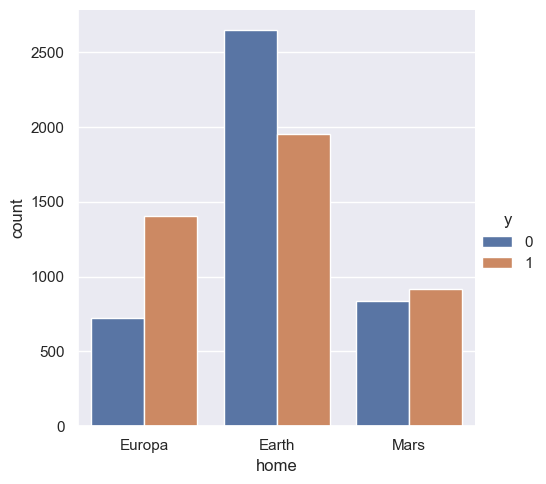

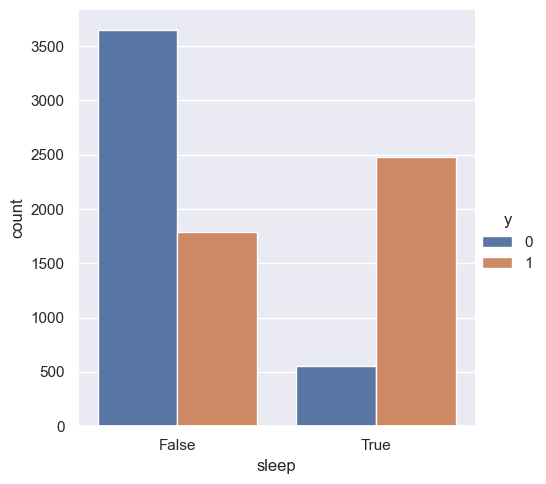

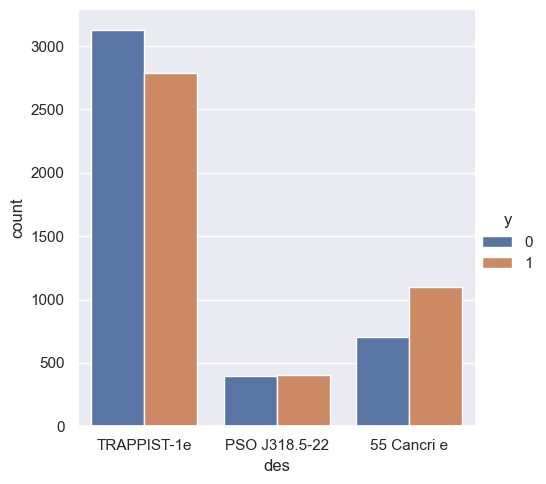

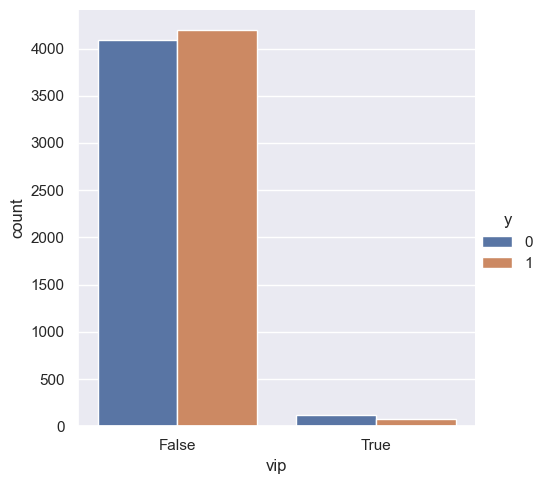

In [173]:
# let's try to understand how the different column behaves in general
for c in non_num:
    if len(df.value_counts(c)) <= 10:
        sns.catplot(kind='count', data=df, x=c, hue='y')
        plt.show()      

Remarks:
* among the categorial features, the most informative feature seems to be CyroSleep. Sleeping passengers are likely to be teleported 
* VIP is not really that informative, as for both VIP and non-VIP, the passengers are almost equally distributed 
* destination and homePlanet as they are currently might not be really informative
* maybe some insight could be extracted from cabin and name: at the moment, they will be dropped


In [174]:
# let's drop the name and cabin features
df, df_test = drop_cols(['name', 'cabin'], df, df_test)

In [175]:
# let's consider the distributions of numerical columns
print(df.describe()) 

               age          room          food          mall           spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

               deck            y  
count   8505.000000  8693.000000  
mean     304.854791     0.503624  
std     1145.717189     0.500016  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     1.000000  
75%       46.000000     1.000000  
max    24133.0000

it is easy to see that the maximum values for each of the services in the Titanic SpaceShip are extravagent to say the least.
This should be investigated further.

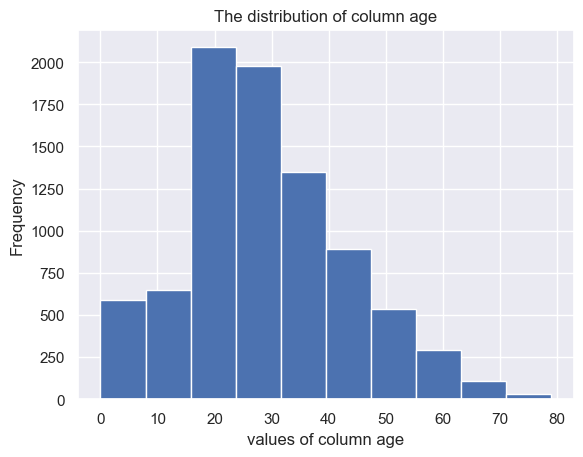

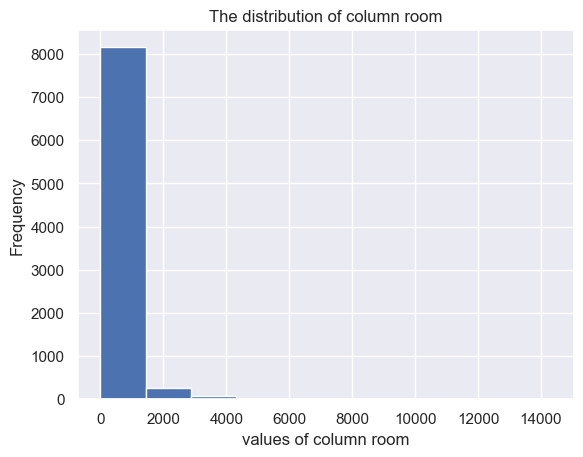

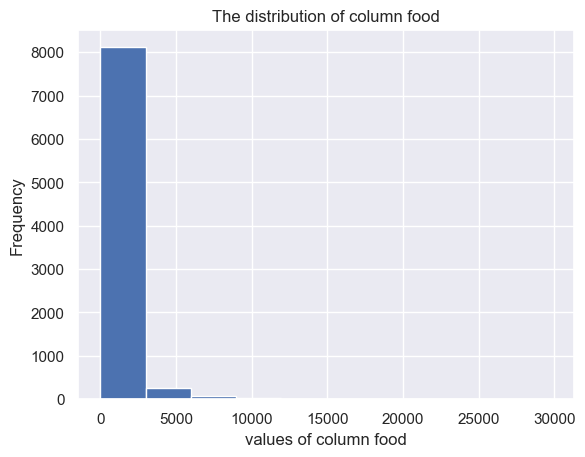

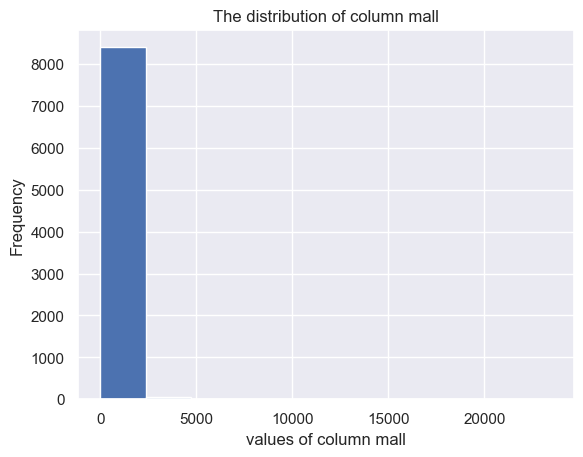

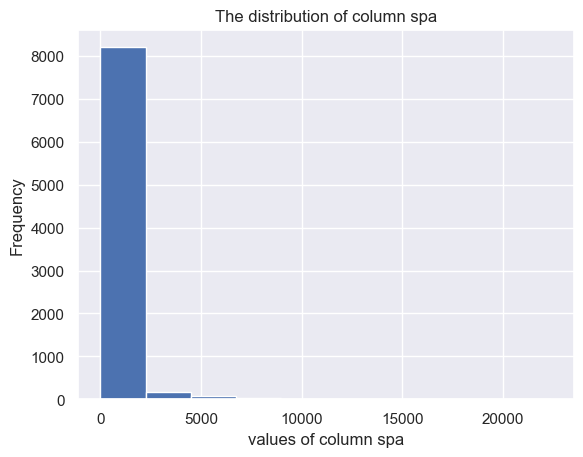

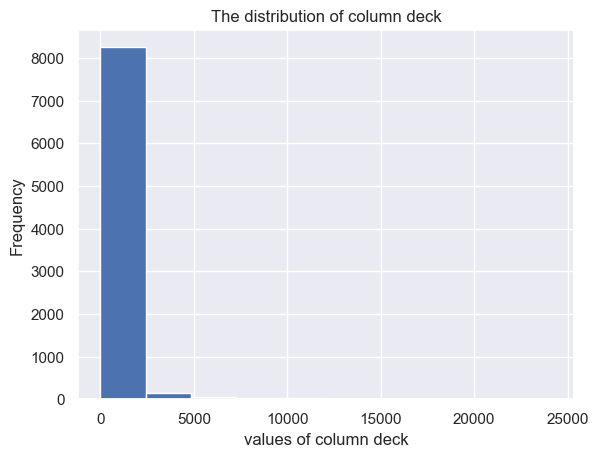

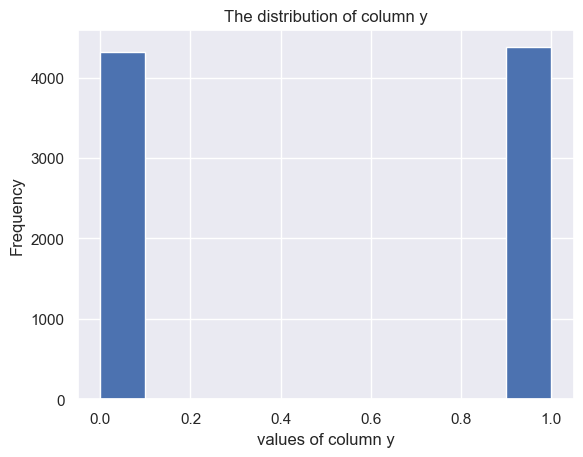

In [176]:
num_cols, non_num_cols = get_col_types(df)
for n in num_cols:
    g = df[n].plot(kind='hist')
    g.set(xlabel=f"values of column {n}", ylabel="Frequency")
    g.set_title(f'The distribution of column {n}')
    plt.show()

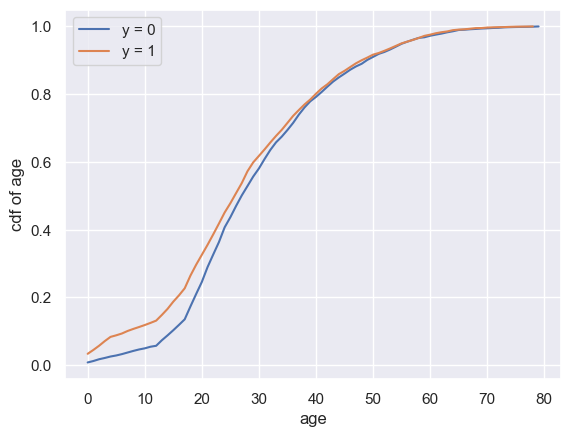

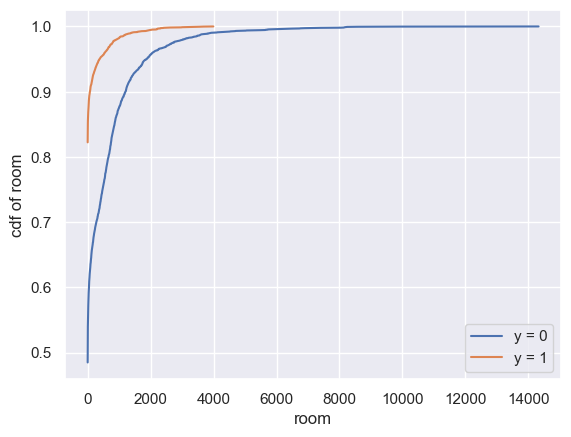

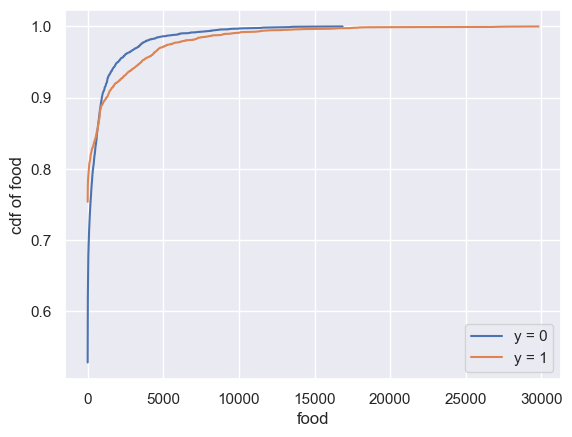

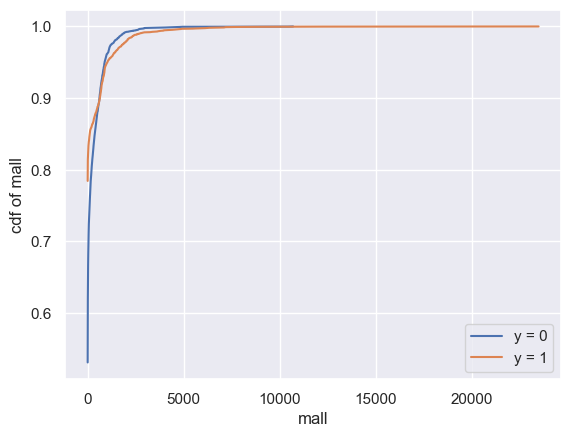

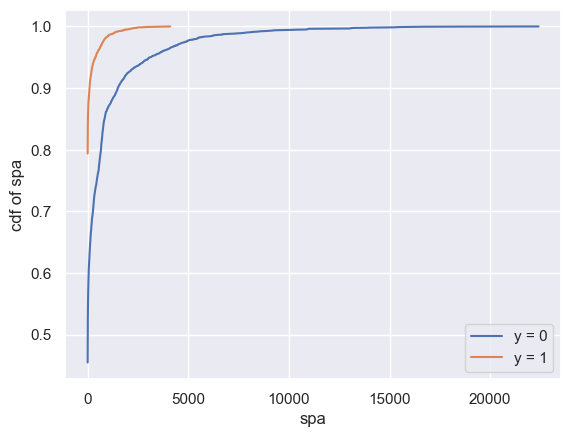

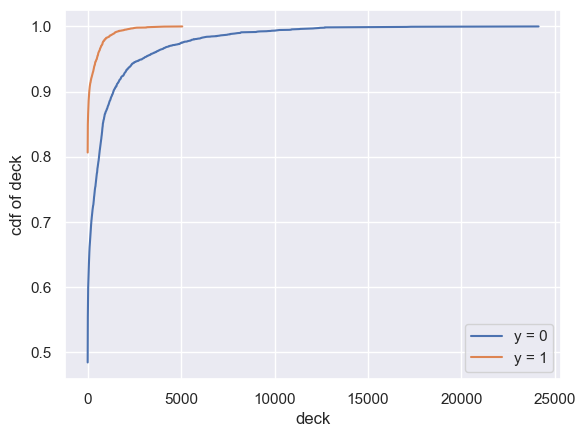

In [177]:
# let's see how these features correlate with "y"
from empiricaldist import Cdf
for n in num_cols[:-1] :
    d1 = df[df['y'] == 0][n]
    d2 = df[df['y'] == 1][n]
    cdf1 = Cdf.from_seq(d1)
    cdf1.plot(label="y = 0")
    
    cdf2 = Cdf.from_seq(d2)
    cdf2.plot(label="y = 1")
    plt.legend()
    plt.xlabel(f'{n}')
    plt.ylabel(f'cdf of {n}')
    plt.show()   

    

* We can see that roomservice + vrdeck + spa share very similar distribution between the different classes (transported and not transported): they can be possibly be combined into a single feature
* the foodcourt and shoppingmall seem to be similar as well


In [178]:
# let's try to understand the percentage of missing values at each column
draw_missing_data_table(df)

,Total,Percent
sleep,217,0.024963
mall,208,0.023927
vip,203,0.023352
home,201,0.023122
deck,188,0.021627
food,183,0.021051
spa,183,0.021051
des,182,0.020936
room,181,0.020821
age,179,0.020591


only few missing values at each column, using "mean" or "median" imputing does not seem like a very bad idea for numerical columns
as for cyrosleep and vip, it might be worth veryfing a certain assumption
1. people in cyrosleep do not spend money at all: 
2. vip: spend significantly more than the rest of the passengers

In [179]:
# first let's add a total_spending column where it calculates the sum of money spent on different services

spending_cols = ['deck','room','food','spa', 'mall']
def total_spent(row):
    spending_cols = ['deck','room','food','spa', 'mall']
    row['total'] = row[spending_cols].sum()
    return row
df, df_test = apply_functions(df, df_test, total_spent)

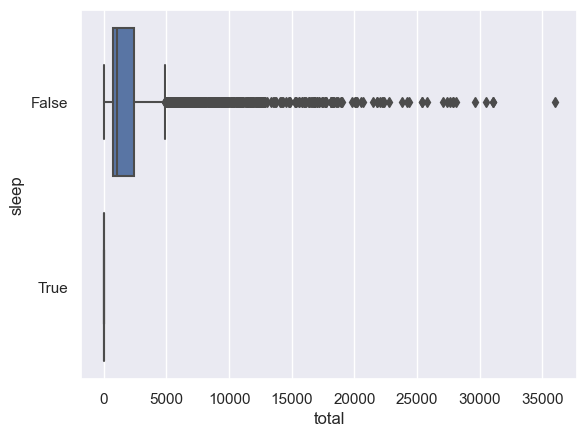

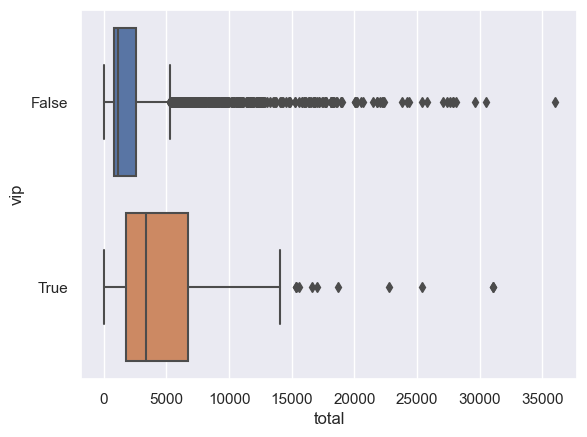

In [180]:
# let's verify our hypothesis

sns.boxplot(data=df, x='total', y='sleep', orient='h')
plt.show()

# let's verify the vip hypothesis

data = df[(df['total'] > 0)]
sns.boxplot(data=data, x='total', y='vip', orient='h')
plt.show()

In [181]:
# the first hypothesis is indeed verified: 
# total == 0 <=> passenger is asleep

# the second hypothesis, is relatively in the correct direction, the mean spending of a vip passenger is significantly 
# larger than the non-vip passenger. it is not possible to determine with high certainty that a high spender is a vip

def impute_total_sleep(row):
    if row['total'] == 0 or row['sleep']:
        for c in spending_cols:
            row[c] = 0
        row['sleep'] = True
        
    return row

In [182]:
spending_cols.append('total')
df_spent = df[df['total']>0]
df_spent_vip = pd.pivot_table(data=df_spent, index=['vip'], values=spending_cols, aggfunc=['median'])
print(df_spent_vip)

      median                                 
        deck   food mall  room    spa   total
vip                                          
False   11.5   16.0  7.0  12.0   19.0  1154.0
True   132.0  488.0  1.0   7.0  133.0  3332.0


In [183]:
import math

def impute_total_vip(row):
    if math.isnan(row['vip']):
        # set the rows with 'vip' missing values to either True or False depending on the
        # total spending 
        if row['total'] > df_spent_vip.loc[False, ('median', 'total')]:
            row['vip'] = True
        else:
            row['vip'] = False
     
    for c in spending_cols:
        if math.isnan(row[c]):
            row[c] = df_spent_vip.loc[row['vip'], ('median', c)]
    return row

df, df_test = apply_functions(df, df_test, impute_total_sleep)
df, df_test = apply_functions(df, df_test, impute_total_vip)

In [184]:
# let's use the median for the moment to impute age
# and the mode for des and home features
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

# impute des and home features

planets=['home', 'des']

df [planets] = pd.DataFrame(data=mode_imputer.fit_transform(df[planets]), columns=planets)
df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])

df_test[planets] = pd.DataFrame(data=mode_imputer.transform(df_test[planets]), columns=planets)
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])


In [185]:
# as expected we have no missing values anymore
draw_missing_data_table(df)

,Total,Percent
home,0,0.0
sleep,0,0.0
des,0,0.0
age,0,0.0
vip,0,0.0
room,0,0.0
food,0,0.0
mall,0,0.0
spa,0,0.0
deck,0,0.0


In [186]:
# final step in the baseline pipeline is to encode the categorial features 
# and convert the boolean ones numerical

df = one_hot_encoder(df, planets)
df_test = one_hot_encoder(df_test, planets)

# remove the original columns
df, df_test = drop_cols(planets, df, df_test)

def set_bool_int(row):
    row['sleep'] = int(row['sleep'])
    row['vip'] = int(row['vip'])
    return row

df, df_test = apply_functions(df, df_test, set_bool_int)


[array(['Earth', 'Europa', 'Mars'], dtype=object)]
[array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]
[array(['Earth', 'Europa', 'Mars'], dtype=object)]
[array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]


before proceeding with the evaluation, I am using an external python file with a number of helper functions mainly concerning hyperparameter tuning and model selection. The cell below will download it for you!!

In [187]:
! wget https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [188]:
# let's remove the 'y' column from the training dataset 
df.pop('y')

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: y, Length: 8693, dtype: int64

In [189]:
from classifiers import tune_model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)

grid= {"C":np.logspace(-3, 3, 20)}

lr = tune_model(lr, grid, df, y)


<module 'matplotlib.pyplot' from 'c:\\Users\\user\\AB\\temp_venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

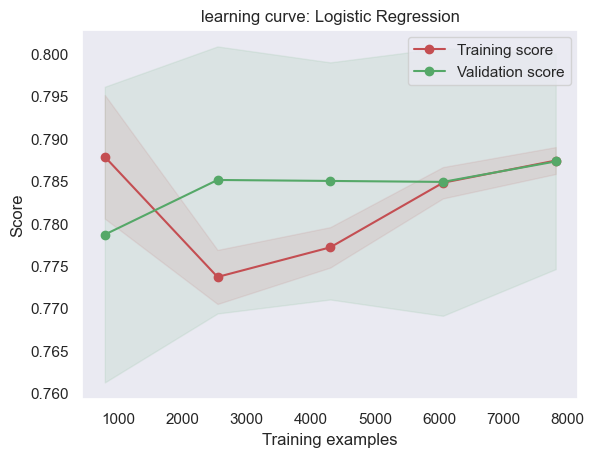

In [190]:
title = "learning curve: Logistic Regression"
cv = 10
plot_learning_curve(lr, title, df, y, cv=cv,n_jobs=-1)

In [191]:
# even though it is clear that Logistic Regression is underfitting the problem
# let's test it on the platfor
create_submission(lr, df, y, df_test, "Logistic Regression", ordered=True)
# the baseline submission scored an accuray of 0.78816
# let's see how far accurate our model can be!!

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,True
9271_01,True


# improving further
In this section I will try to apply a number of feature engineering techniques, further data cleaning and analysis to boost the model's performance. 
Among the points to address:
* attempt to extract insights from cabin and name columns
* address the outliers in the spending columns + vip column
* better encoding and impuation for home and des columns


In [192]:
# let's reconsider the original dataset
df = df_org.copy()
df_test = df_test_org.copy()
# let's first add the total column
# as well as impute the sleep and the spending columns
df, df_test = apply_functions(df, df_test, total_spent)
df, df_test = apply_functions(df, df_test, impute_total_sleep)


df = df.astype({"vip": bool, "sleep": bool})
df_test = df_test.astype({"vip": bool, "sleep": bool})


## Does destination or origin matter ?

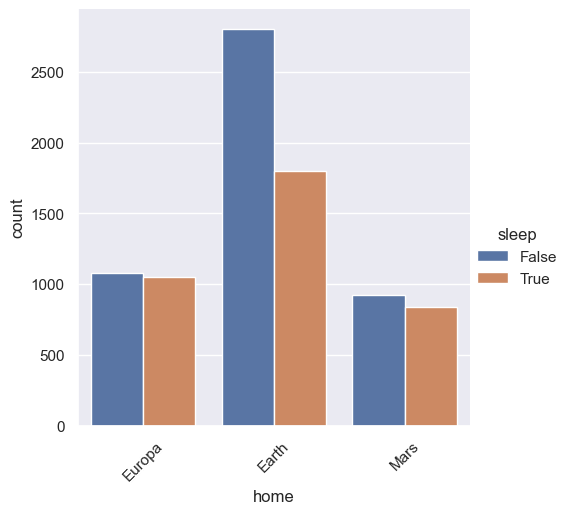

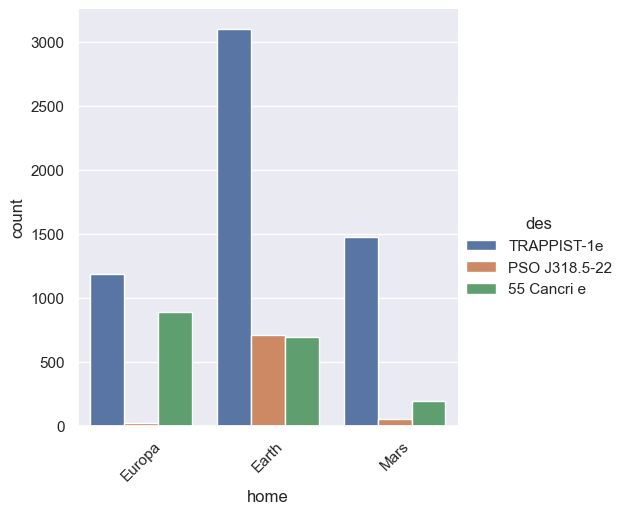

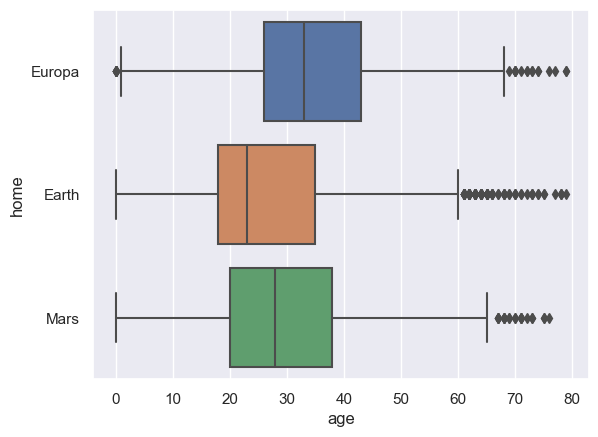

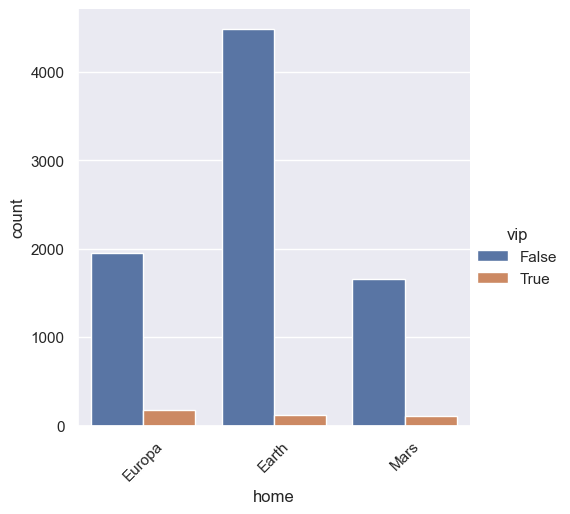

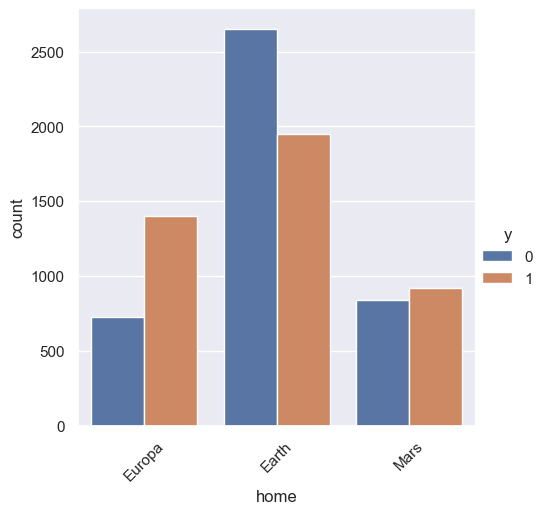

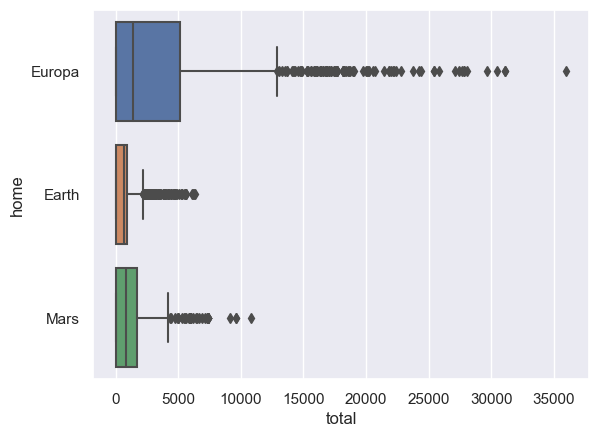

In [193]:
# let's see how 'home' and 'des' features interact with the rest of the features
# outside of the spending columns, consider only the "total" feature 
use_cols = [c for c in df.columns if c not in ['mall', 'food', 'room','deck', 'spa']]
# let's first consider the 'home' feature
visualize_interaction(df, "home", use_cols=use_cols)

* Earth has the most passengers
* Europa's passengers do not visit PSO
* Earth has no vip people
* Europe is the richest planet and with 2 thirds of its passengers getting transported

In [194]:
# after calling 
# visualize_interaction(df, 'des', use_cols=use_cols) 
# the 'des' features was deemed non-informative
# thus, it seems reasonable to binarize the 'home' feature and drop the 'des' feature

# let's calculate q3 for Mars
q3_mars = np.quantile(df[df['home'] == 'Mars']['total'], [0.75])[0]
print(q3_mars)

# let's binarize the 'home' feature while 
def new_home(row):
    # let's try to impute the value if it is nan:
    try:
        if math.isnan(row['home']):
            # if the destination is 'POS'... then "home" is not Europe
            try:
                if row['des'].lower().startswith('pos') or row['total'] <= q3_mars:
                    row['is_Europe'] = False
                else: 
                    row['is_Europe'] = True
            except AttributeError:
                # this block is accessed if row['des'] or row['total'] is nan
                # statistically, having the passenger's home as Europe is less likely than other planets
                row['is_Europe'] = False   
       
    except TypeError:
        # a TypeError means row['home'] is not Nan
        row['is_Europe'] = row['home'] == 'Europe'

    return row


1686.5


In [195]:
df, df_test = apply_functions(df, df_test, new_home)

# drop the home and des features
df, df_test = drop_cols(['des', 'home'], df, df_test)

## Cabin, Passenger_Id, Name: any insights ? 
After reading the data description more carefully, it can be seen that cabin, passenger_id and name column are not completely useless. Let's see if some feature engineering could put these columns to use

In [196]:
# let's first restore the passenger_id column
df['id'] = train_data['PassengerId']
df_test['id'] = test_data['PassengerId']

def group_number(row):
    g, n = [int(s) for s in row['id'].strip().split("_")]
    row['group'] = g
    return row

df, df_test = apply_functions(df, df_test, group_number)


In [197]:
def split_cabin(row):
    try:
        d, n, side = row['cabin'].split("/")
        row['deck_num'] = d
        row['cabin_num'] = n
        row['side'] = side
    except:
        pass
    return row

def split_name(row):
    try:
        row['name'] = row['name'].strip().split(" ")[1].lower()
    except:
        pass
    return row

df, df_test = apply_functions(df, df_test, split_cabin)
df, df_test = apply_functions(df, df_test, split_name)   


In [198]:
new_feats = ['deck_num', 'cabin_num', 'side', 'name', 'group']
for f in new_feats:
    u = df[f].value_counts()
    if len(u) <= 10:   
        print(u)
    else:
        print(f"feature {f} has {len(u)} unique values")

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: deck_num, dtype: int64
feature cabin_num has 1817 unique values
S    4288
P    4206
Name: side, dtype: int64
feature name has 2217 unique values
feature group has 6217 unique values


We can see that there are many families (more than 2200 unique surname). The feature as it is, is not very informative. However, we can assign a number of family members to each passenger. This value can be approximated with high certainty by the value_counts() function call on the "number" feature
however it can be done definitely using the name feature.   
The group, number, cabin_num and name (after preprocessing) features will be discarded 


In [199]:
# let's use the entire dataset for extracting the family sizes 
alldata = pd.concat([df.drop('y', axis=1), df_test])
group_sizes = alldata.value_counts('group')
fam_sizes = alldata.value_counts('name')

def set_group_size(row):
    # this function is used mainly to later impute the 'fam_size' with the value of the group the row belongs to 
    try:
        row['group'] = group_sizes.loc[row['group']]
    except:
        pass
    return row

def set_fam_size(row):
    try:
        row['fam_size'] = fam_sizes.loc[row['name']]
    except:
        row['fam_size'] = row['group']
    return row 


# make sure to apply the set_group_size first
df, df_test = apply_functions(df, df_test, set_group_size)
df, df_test = apply_functions(df, df_test, set_fam_size)

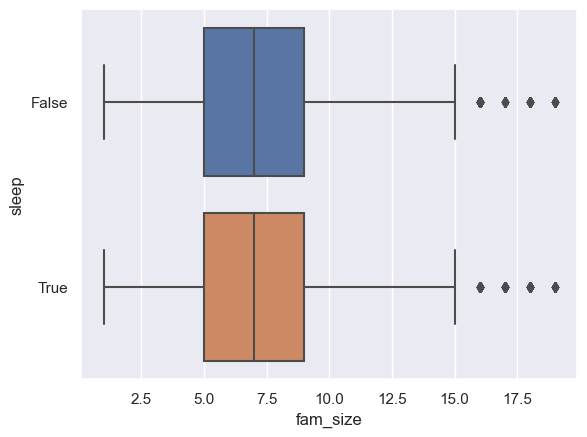

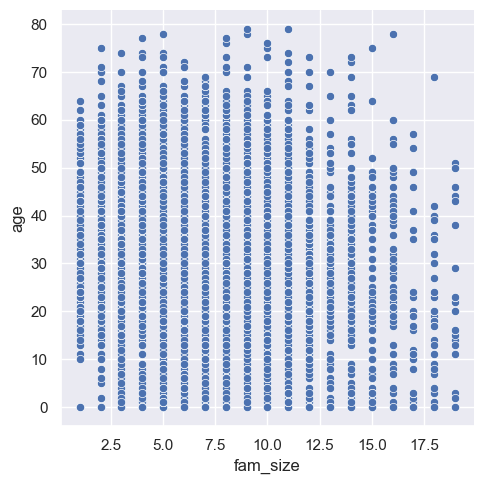

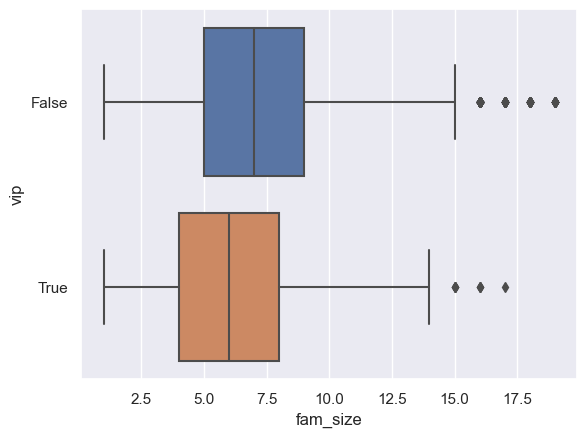

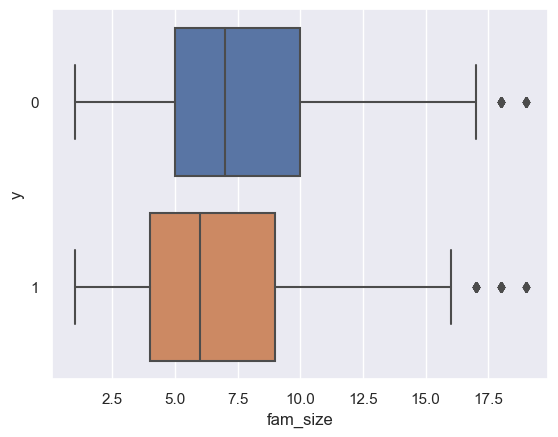

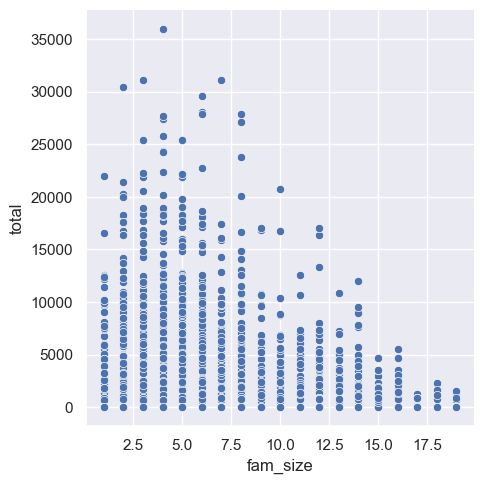

In [200]:
# let's consider the interaction of 'fam_size' with the other features
use_cols.remove('home')
use_cols.remove('des')
visualize_interaction(data=df, feature='fam_size', use_cols=use_cols)

## As Dom says , Family First

In [201]:

# before proceeding to extract insight from grouping the passengers by their families, let's impute the 'name' feature
# the first step is to group the passengers by the 'group' feature, if the 'name' feature is nan for one row, then we can impute it by the most frequent name
# in the 'group' for which that row belongs
from statistics import mode

names_by_group = pd.pivot_table(alldata, values='name', index=['group'], aggfunc=mode)

def impute_name(row):
    global names_by_group
    try:
        if math.isnan(row['name']):
            row['name'] = names_by_group.loc[row['group'], 'name']
        
    except TypeError:
        # this means row['name'] is not nan
        pass
   
    return row

# impute the name feature
df, df_test = apply_functions(df, df_test, impute_name)
print(df['name'].isna().sum(), df_test['name'].isna().sum(), sep='\t')
# fortunately, the set of nan names and nan groups are mutually exclusive, names imputed successfully!!!

0	0


In [202]:
# the final dataframe is the concatenation of all these small modified family frames

def extract_age_in_fam(dataframe:pd.DataFrame):
    new_cols = list(dataframe.columns)
    new_cols.append('age_in_fam')
    new_df = pd.DataFrame([], columns=new_cols)
    by_fam = dataframe.groupby('name')
    for _, fam in by_fam:
        new_frame = fam.reset_index().set_index(pd.RangeIndex(start=1, stop=len(fam) + 1)).reset_index().sort_values(by='age')
        new_frame['age_in_fam'] = (new_frame['level_0']) / len(new_frame)
        new_frame = new_frame.drop('level_0', axis=1).set_index('index')
        new_df = pd.concat([new_df, new_frame], ignore_index=False)
    return new_df

# this function should be applied on the entire data
df['is_train'] = 1
df_test['is_train'] = 0
all_data = pd.concat([df, df_test], ignore_index=False)

all_data = extract_age_in_fam(all_data)

C:\Users\user\AppData\Local\Temp\ipykernel_11716\756711017.py:12: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  new_df = pd.concat([new_df, new_frame], ignore_index=False)
C:\Users\user\AppData\Local\Temp\ipykernel_11716\756711017.py:12: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  new_df = pd.concat([new_df, new_frame], ignore_index=False)
C:\Users\user\AppData\Local\Temp\ipykernel_11716\756711017.py:12: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  new_df = pd.concat([new_df, new_frame], ignore_index=False)
C:\Users\user\AppData\Local\Temp\ipykernel_11716\756711017.py:12: FutureWarning: In a future vers

In [203]:
df = all_data[all_data['is_train'] == 1]
df_test = all_data[all_data['is_train'] == 0]

In [204]:
# the data's integrity verified
print((train_data.sort_values(by='PassengerId')['PassengerId'].values == df.sort_values(by='id')['id'].values).all())
print((test_data.sort_values(by='PassengerId')['PassengerId'].values == df_test.sort_values(by='id')['id'].values).all())

True
True


In [205]:
# let's consider the mean age and mean spending of each family
family_stats = pd.pivot_table(alldata, index='name', values=['age', 'total'], aggfunc=['mean', 'count', 'median', 'sum', 'max', 'min'])
family_stats

mean              count       median            sum  \
                   age        total   age total    age   total    age   
name                                                                    
acobson      23.800000   842.400000     5     5   18.0   796.0  119.0   
acobsond     27.125000   683.750000     8     8   24.5   640.0  217.0   
adavisons    19.800000   578.800000    10    10   22.0   790.0  198.0   
adkinson     24.000000  1061.500000     3     4   19.0   414.5   72.0   
admingried   29.250000  4071.250000     4     4   29.5  2006.0  117.0   
...                ...          ...   ...   ...    ...     ...    ...   
wynneyerson  26.500000   359.000000     2     2   26.5   359.0   53.0   
yanton       27.125000  1059.750000     8     8   26.5   900.5  217.0   
yatters      22.000000   623.750000     8     8   24.5   679.5  176.0   
yorkland     25.750000   835.230769    12    13   24.0   869.0  309.0   
youngrayes   29.285714   599.000000     7     7   30.0   791.0  205.0   

                       max            min         
               total   age    total   age  total  
name                                              
acobson       4212.0  39.0    982.0  15.0  776.0  
acobsond      5470.0  47.0   1800.0  13.0    0.0  
adavisons     5788.0  51.0   1445.0   1.0    0.0  
adkinson      4246.0  38.0   3417.0  15.0    0.0  
admingried   16285.0  39.0  12273.0  19.0    0.0  
...              ...   ...      ...   ...    ...  
wynneyerson    718.0  34.0    718.0  19.0    0.0  
yanton        8478.0  48.0   2055.0  13.0    0.0  
yatters       4990.0  40.0   1873.0   0.0    0.0  
yorkland     10858.0  53.0   2330.0   1.0    0.0  
youngrayes    4193.0  39.0    970.0  17.0    0.0  

[2406 rows x 12 columns]

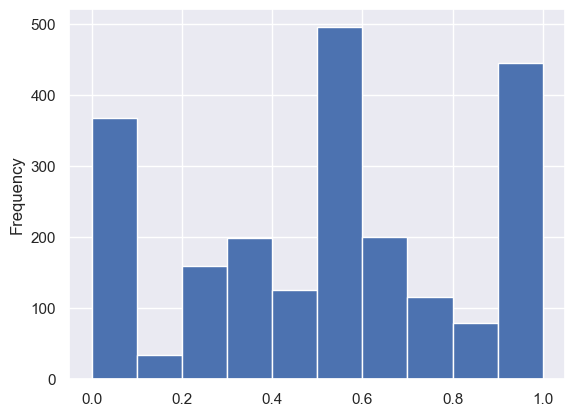

In [206]:
# the transportation rate differs from one family to another, with 0, 0.5 and 1 being the most common values.
fam_transportation = pd.pivot_table(df, index='name', values=['y'], aggfunc=['mean', 'count'])
# print(fam_survival.sort_values(by=('mean', 'y'), ascending=False)) 
# let's visualize the the distribution of the survival rate among families
fam_transportation.reset_index()[('mean', 'y')].plot(kind='hist')
plt.show()

In [207]:
# let's add some fam/total, fam/age features

def set_fam_age(row):
    global family_stats
    # consider adding the median age of the passenger's family
    row['fam_age'] = family_stats.loc[row['name'], ('median', 'age')]    
    return row

def set_fam_total(row):
    global family_stats
    row['fam_total_frac'] = min(1, row['total'] / (family_stats.loc[row['name'], ('sum', 'total')] + 1))  
    return row

df, df_test = apply_functions(df, df_test, set_fam_age)
df, df_test = apply_functions(df, df_test, set_fam_total)


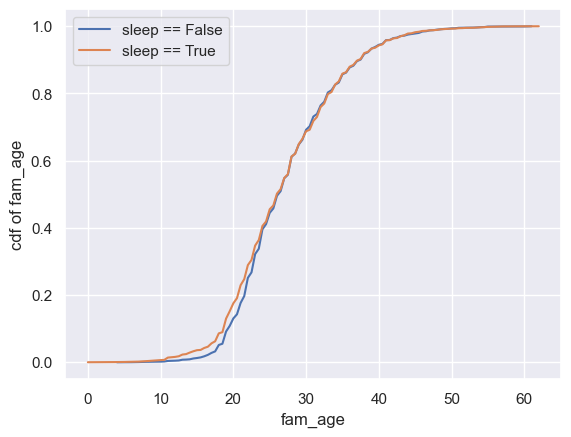

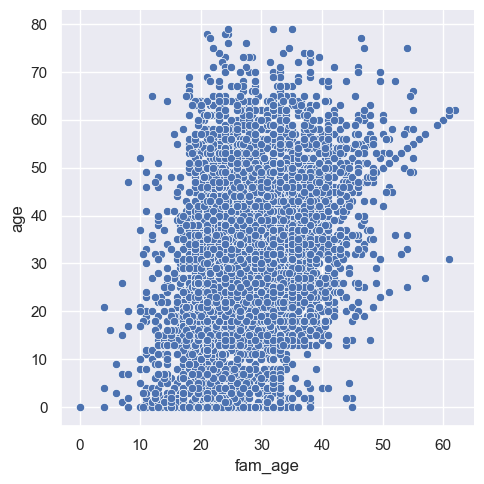

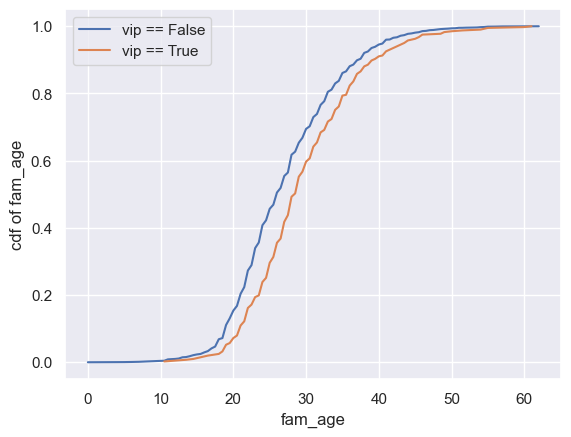

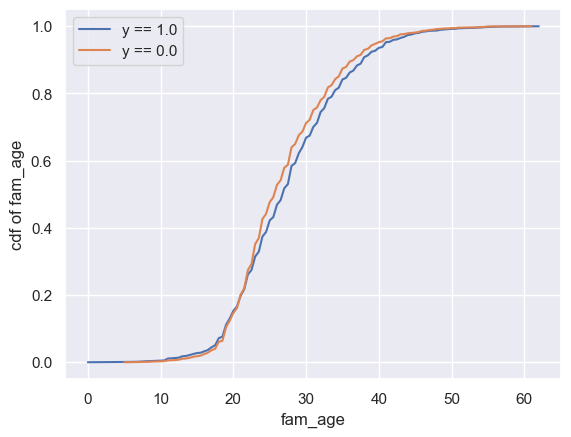

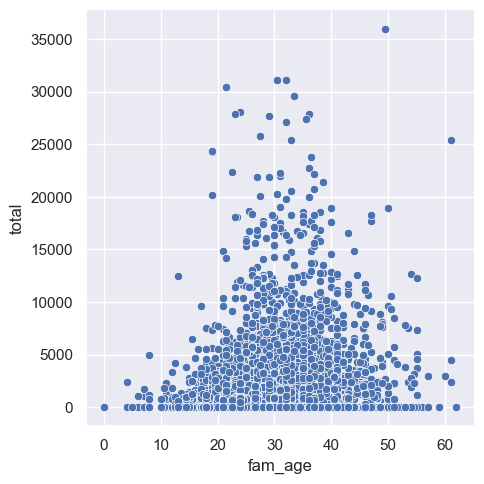

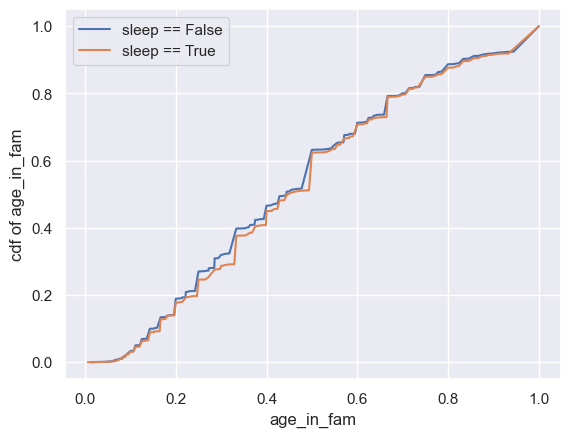

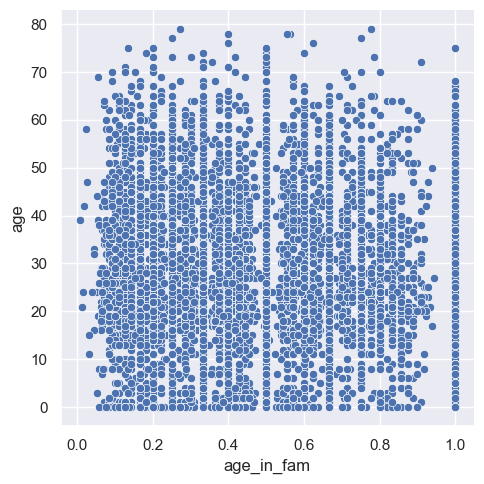

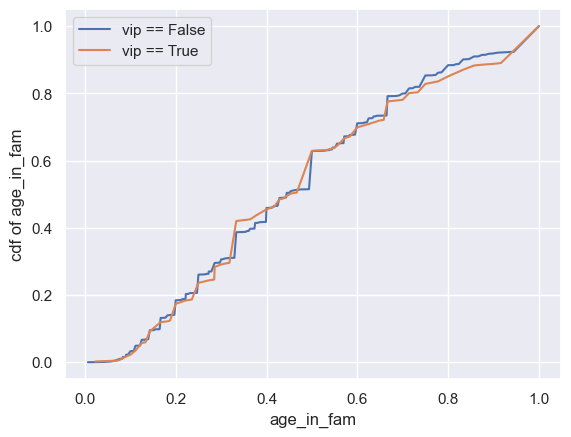

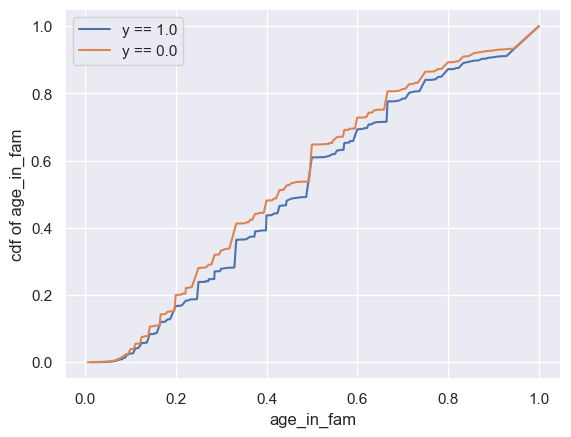

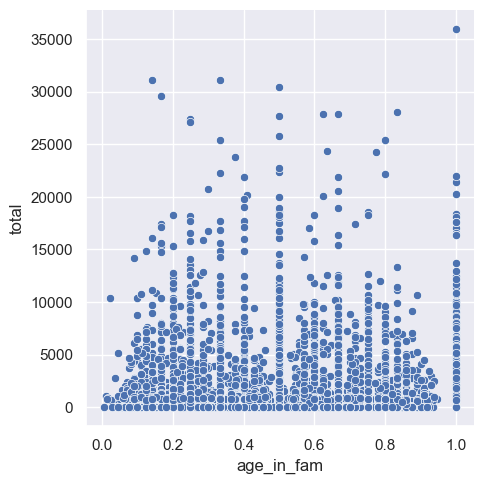

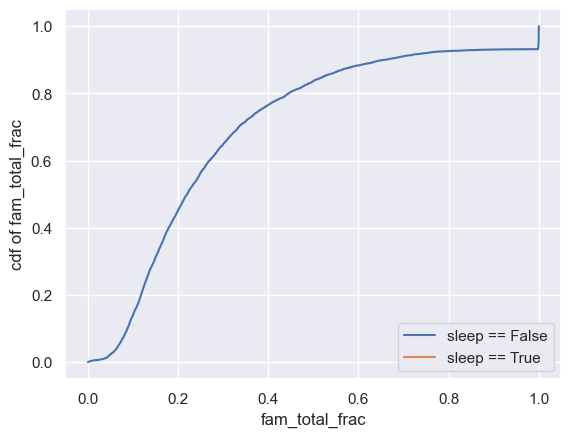

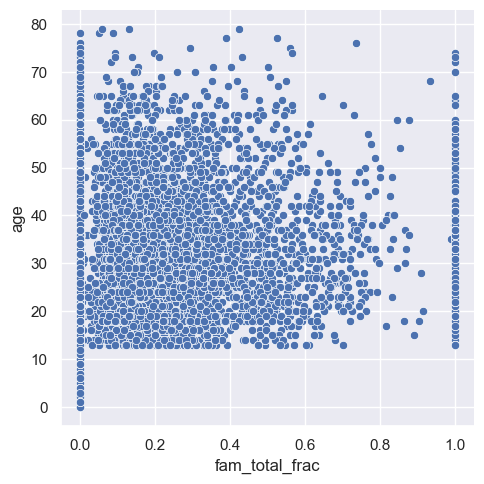

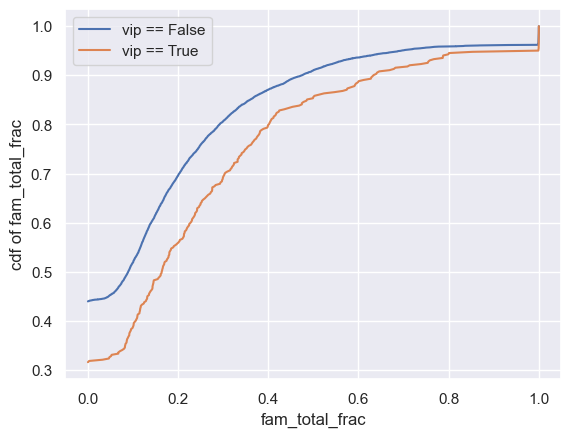

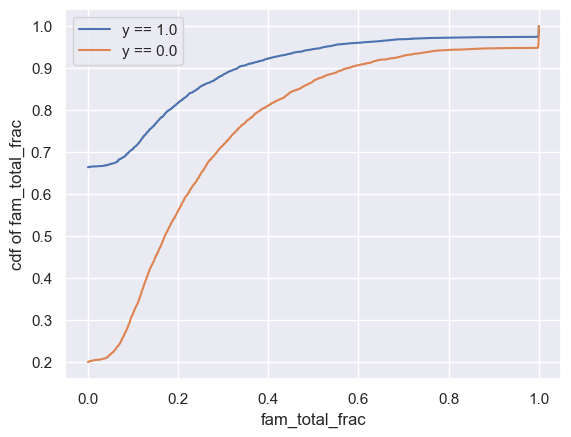

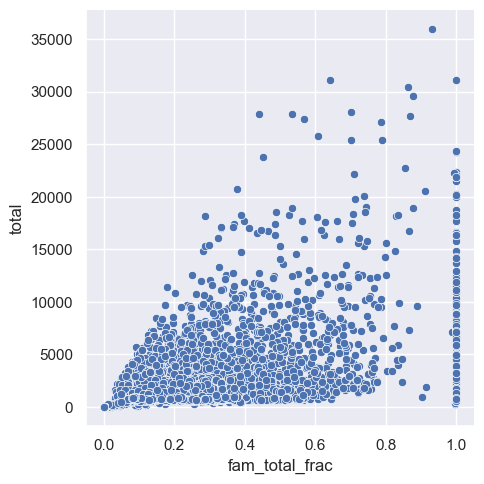

In [208]:
# let's consider the impace of these new features
fam_feats = ['fam_age', 'age_in_fam', 'fam_total_frac']
# use = [c for c in use_cols if c not in ['total', 'age']]
for f in fam_feats:
    visualize_interaction(data=df, feature=f, use_cols=use_cols, num_cat='cdf')

* fam_total_frac seems to be an informative feature, as 0.7\% of those transported are have a value of 0 on their fam_total_frac feature while only 20\% of the non-transported features have the same value
* the distribution of the "total" feature seems normal with respect of the "fam_age" feature


In [209]:
# the only features left to impute is the age
def impute_age(row):
    # the main idea is to use multiply the fam_total_frac * range(fam_age) + min_fam_age
    if math.isnan(row['age']):
        min_fam_age = family_stats.loc[row['name'], ('min', 'age')]
        max_fam_age =  family_stats.loc[row['name'], ('max', 'age')]
        row['age'] =  min_fam_age + row['fam_total_frac'] * (max_fam_age - min_fam_age)
        
    return row

df, df_test = apply_functions(df, df_test, impute_age)

In [210]:
df.head()
df, df_test = drop_cols(['is_train', 'cabin', 'cabin_num', 'deck_num', 'group', 'name', 'side'], df, df_test)
df.set_index('id')
df_test.set_index('id')

,age,deck,food,is_Europe,mall,room,sleep,spa,total,vip,y,fam_size,age_in_fam,fam_age,fam_total_frac
id,,,,,,,,,,,,,,,
4353_01,18.000000,0.0,40.0,False,0.0,736.0,False,0.0,776.0,False,NaN,5,1.000000,18.0,0.184192
5873_03,21.000000,3.0,0.0,False,0.0,0.0,False,639.0,642.0,False,NaN,8,1.000000,24.5,0.117346
1459_01,23.000000,419.0,36.0,False,0.0,183.0,False,0.0,638.0,False,NaN,8,0.500000,24.5,0.116615
5873_01,24.000000,735.0,0.0,False,12.0,0.0,False,161.0,908.0,False,NaN,8,0.750000,24.5,0.165966
1930_01,25.000000,0.0,0.0,False,1.0,599.0,False,0.0,600.0,False,NaN,8,0.625000,24.5,0.109669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448_01,4.002486,0.0,571.0,False,0.0,20.0,False,36.0,627.0,False,NaN,13,0.923077,24.0,0.057740
4761_02,17.000000,0.0,0.0,False,0.0,0.0,True,0.0,0.0,False,NaN,7,0.714286,30.0,0.000000
5866_01,30.000000,0.0,627.0,False,0.0,1.0,False,0.0,628.0,False,NaN,7,1.000000,30.0,0.149738


### who gets_transported in a family ?

In [211]:
# # do not forget to remove the cabin, and idPassenger features
# df, df_test = drop_cols(['cabin', 'id'], df, df_test)

# # drop the unncessary features
# # df, df_test = drop_cols(['name', 'number', 'group', 'cabin_num'], df, df_test)

# # let's consider the distribution of the new features
# new_feats = ['deck_num', 'side', 'fam_size']
# for nf in new_feats:
#     sns.catplot(kind='count', data=df, x=nf, hue='y')
#     plt.show()


# # let's consider the spending per family
# df['total_per_fam'] = df['total'] / df['fam_size'] 
# df_test['total_per_fam'] = df_test['total'] / df_test['fam_size'] 


# sns.histplot(data=df, x='total_per_fam')
# plt.show()


# # the new features might have certain interactions with both vip and total features
# # fam_size
# sns.relplot(data=df, x='fam_size', y='total', hue='y', size='vip')
# plt.show()
# # cabin_num
# sns.boxplot(data=df, y='deck_num', x='total', orient='h', hue='y')
# plt.show()

## SPENDING OUTLIERS

The main observation is that under a certain trehshold most pair of spending are highly positevely correlated. Nevertheless, as the spending increases, most pair of spending start correlating negatively.
Let's consider the the IQR values to detect outliers and consider in more depth their behavior

In [212]:
# let's define a function to extract the necessary percentiles
def outliers (df:pd.DataFrame, spending_col):  
    data = df[df[spending_col] > 0]
    q1, q3 = np.quantile(np.asarray(data[spending_col]), [0.25, 0.75])
    iqr = q3 - q1
    min_ = max(0, q1 - 1.5 * iqr)
    max_ = q3 + 1.5 * iqr
    return min_, max_

spending_limits = dict(zip(spending_cols, [outliers(df, c) for c in spending_cols]))
print(spending_limits)

{'deck': (0, 1971.5), 'room': (0, 2065.125), 'food': (0, 3025.75), 'spa': (0, 1882.0), 'mall': (0, 1699.5), 'total': (0, 5401.0)}


In [213]:
sp_out = 'spending_outlier'
def set_spending_outliers(row):
    global spending_limits
    spending_cols = ['deck','room','food','spa', 'mall', 'total']
    row[sp_out] = 0
    for c in spending_cols:
        limits = spending_limits[c]
        if row[c] > limits[1] or row[c] < limits[0]:
            row[sp_out] += 1
    return row


df, df_test = apply_functions(df, df_test, set_spending_outliers)

In [214]:
# what is special about these outlier
df_outliers = df[df[sp_out] > 0]
num, cat = get_col_types(df_outliers)

print(df_outliers['y'].value_counts())
print(f"{df_outliers['y'].value_counts()[0] / df_outliers['y'].value_counts().sum()} of the outliers are not transported")

0.0    783
1.0    384
Name: y, dtype: int64
0.6709511568123393 of the outliers are not transported


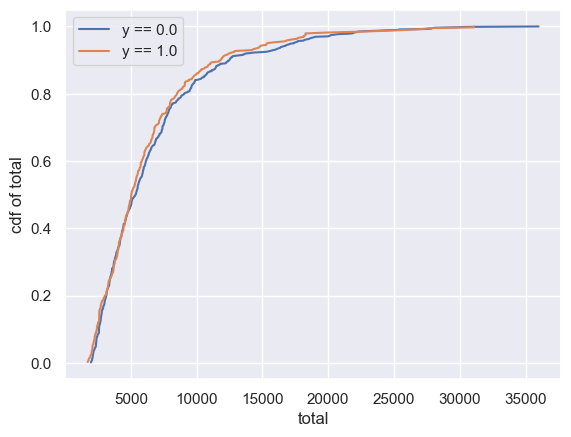

In [215]:
# let's consider how the total spending varies amoung the outliers
visualize_interaction(df_outliers, feature='total', use_cols=['y'], num_cat='cdf')
# the distribution below shows that the exact amount spent is irrelevant for the transportation
# after reaching a certain spending treshhold, the exact amount is irrelevant

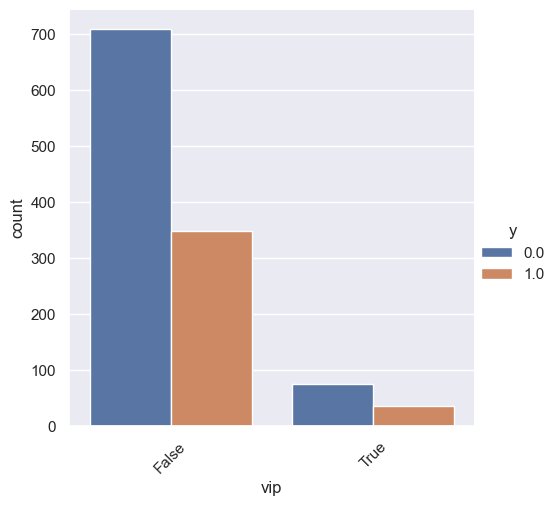

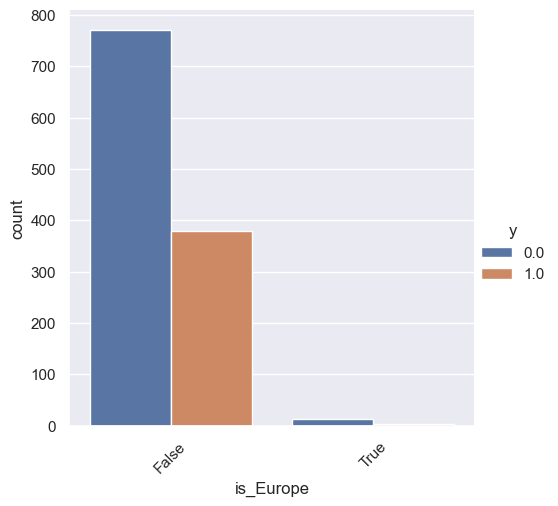

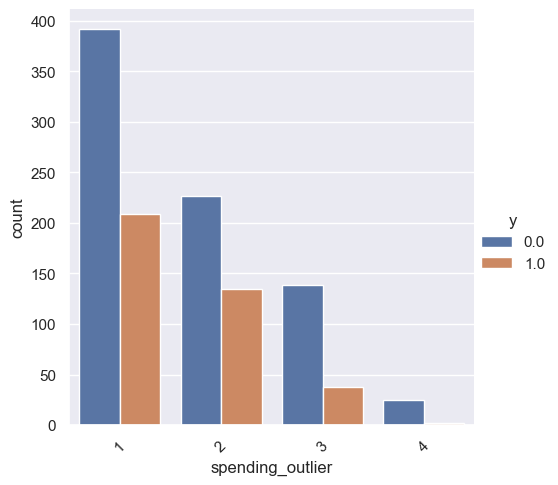

cabin is not part of the dataframe's features


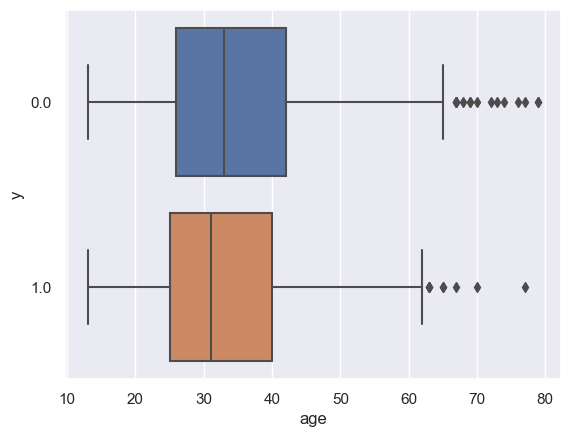

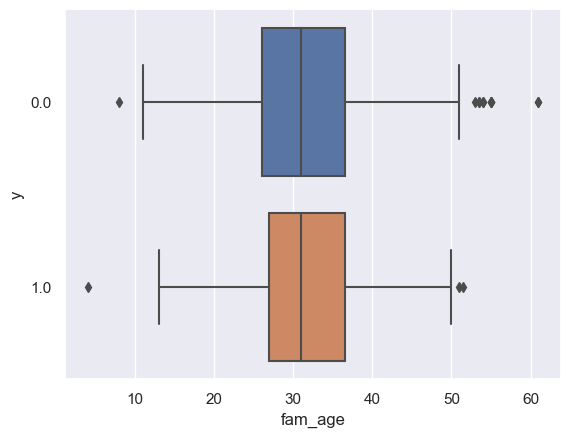

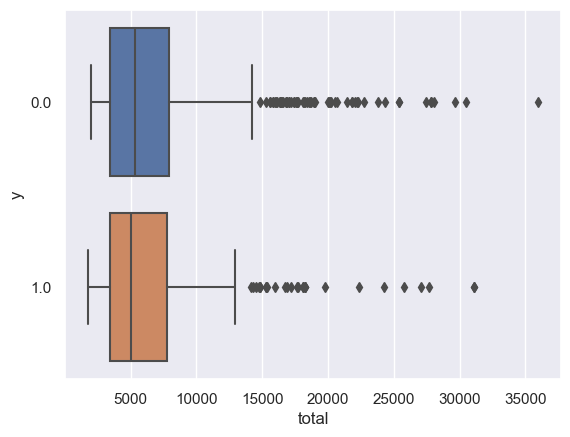

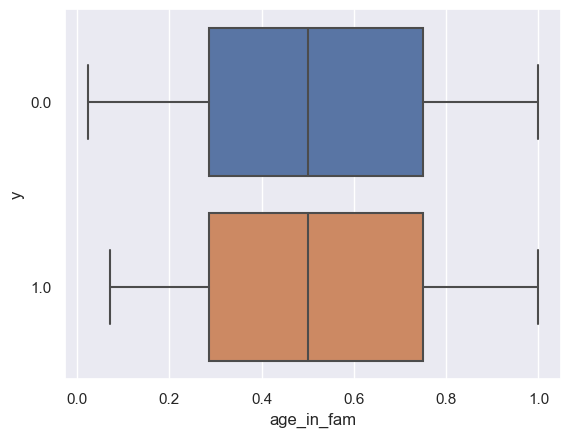

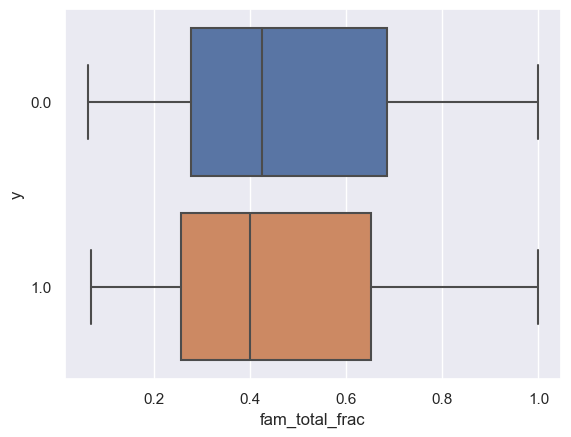

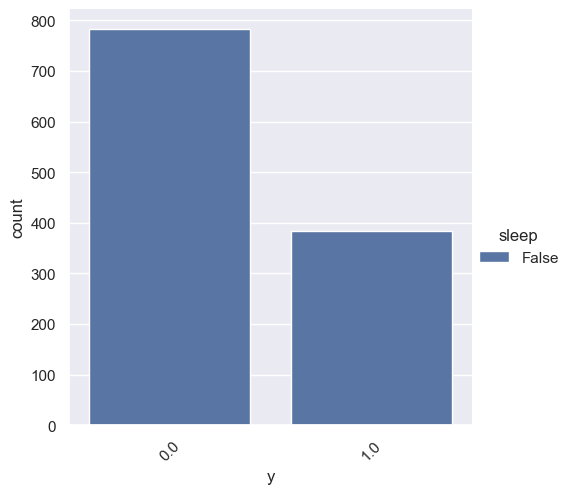

name is not part of the dataframe's features


In [216]:
# let's understand why third of the outliers get transported
# let's visualize the intercation of the each feature with the target

use_cols.extend(["is_Europe", sp_out, 'fam_age', 'age_in_fam', 'fam_total_frac'])
for u in set(use_cols):
    visualize_interaction(df_outliers, feature=u, use_cols=['y'])

It is settled. An outlier is transported only when they are not from Europe (doesn't seem fair though!!)

## a world with no outliers is a better world ??
In this subsection, I will proceed to understand the distribution of non-outliers.

In [217]:
df_no = df[df[sp_out] == 0]
df_test_no = df_test[df_test[sp_out] == 0]

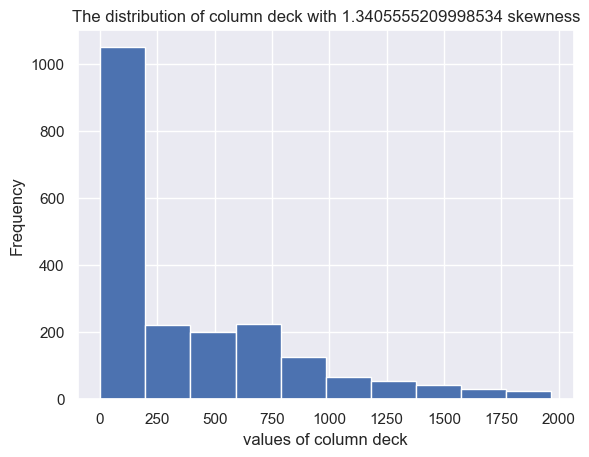

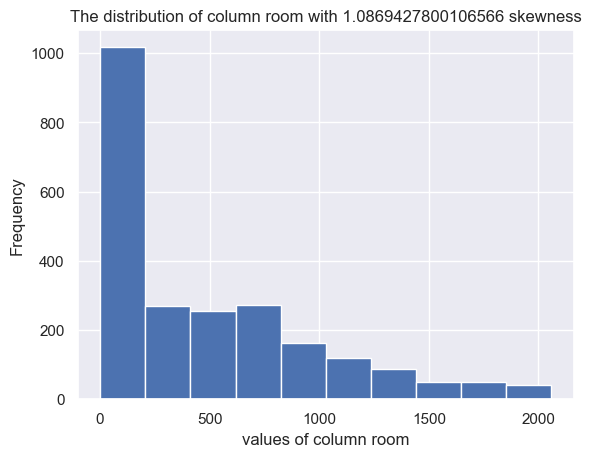

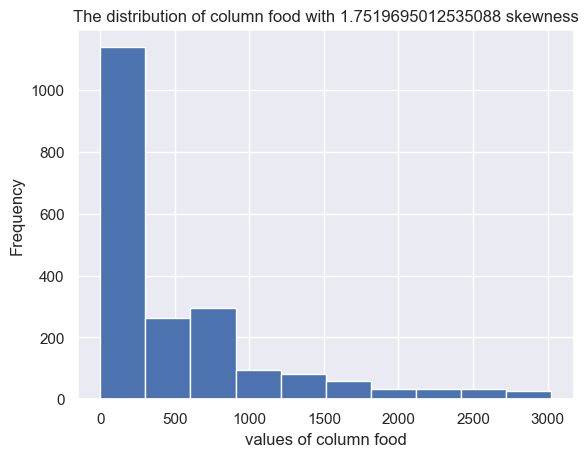

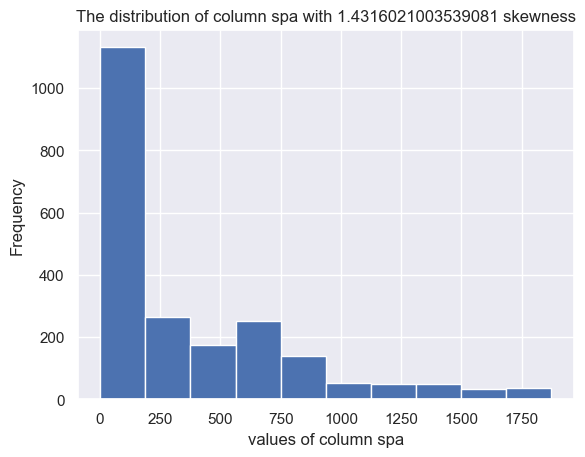

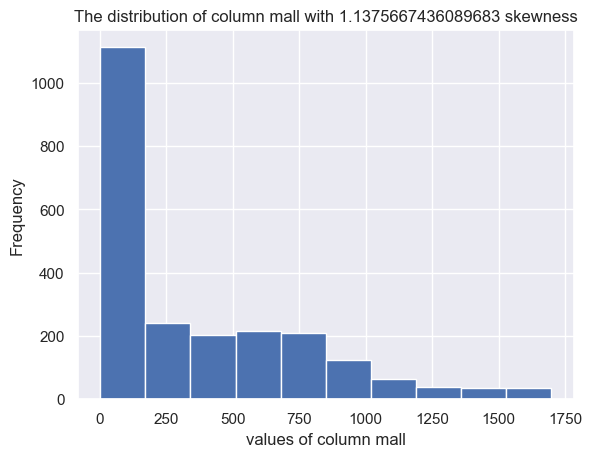

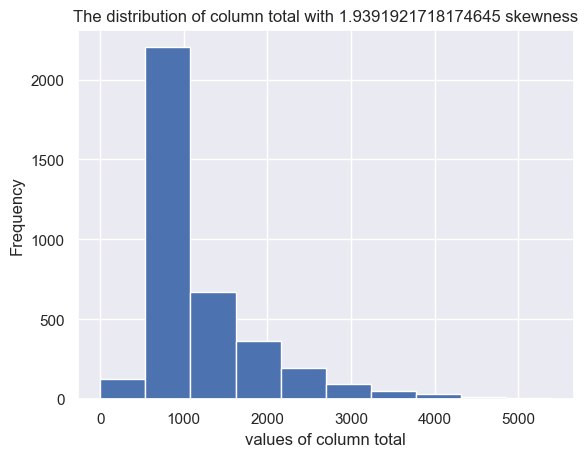

In [218]:
# let's better understand how the spending columns vary for non-outliers
# let's consider the non-sleeping customers
for c in spending_cols:
    col = df_no[df_no[c] != 0][c] 
    g = col.plot(kind='hist')
    g.set(xlabel=f"values of column {c}", ylabel="Frequency")
    g.set_title(f'The distribution of column {c} with {col.skew()} skewness')
    plt.show()


# we definitely see an improvement in comparison to the distribution with the entire dataset

In [219]:
# let's apply log function to each column in the spending column
def transform(row):
    spending_cols = ['deck','room','food','spa', 'mall']
    for c in spending_cols:
        if row[c] > 0 :#and not math.isnan(row[c]):
            row[c] = np.log(row[c])
    row['total'] = 1 / (1 + row['total'])
    return row


In [220]:
df_no, df_test_no = apply_functions(df_no, df_test_no, transform)

In [221]:
# Based on the results displayed above, any value above the maximum (q3 + IQR * 1.5) will be set to the maximum value, in the mean time, the spending_outlier 
# will still be used. 
# the other spending columns will be dropped


spending_cols.remove('total')
df, df_test = drop_cols(spending_cols, df, df_test)
df, df_test = drop_cols(['sleep'], df, df_test)

# plug the 'total' feature
def set_total(row):
    row['total'] = min(row['total'], spending_limits['total'][1])
    return row
df, df_test = apply_functions(df, df_test, set_total)
df, df_test = apply_functions(df, df_test, funcs=[lambda x : 1  / ( 1 + x)], col_names=['total'])
# drop the row with the na value in the training data


In [222]:
# impute the missing values with the mode o
mode_imputer = SimpleImputer(strategy='most_frequent')

df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])

df [['fam_age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['fam_age']]), columns=['fam_age'])
df_test[['fam_age']] = pd.DataFrame(data=median_imputer.transform(df_test[['fam_age']]), columns=['fam_age'])


# Submission
The results displayed in the last section, led to the final dataset that will later be used in

In [223]:
y = df['y']
df, df_test = drop_cols(['y'], df, df_test)

lr = LogisticRegression(max_iter=5000)

grid= {"C":np.logspace(-3, 3, 20)}

lr = tune_model(lr, grid, df, y)


<module 'matplotlib.pyplot' from 'c:\\Users\\user\\AB\\temp_venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

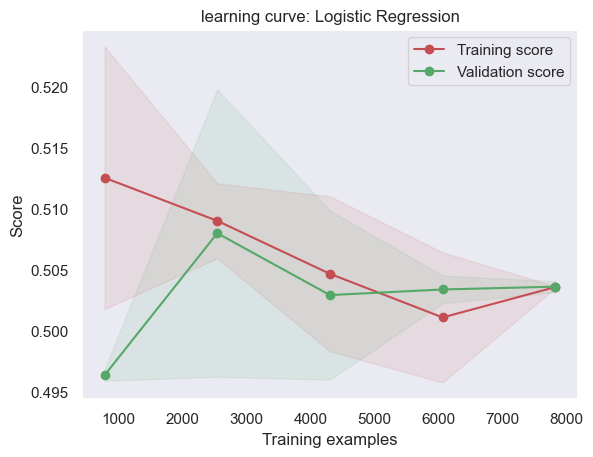

In [224]:
title = "learning curve: Logistic Regression"
cv = 10
plot_learning_curve(lr, title, df, y, cv=cv,n_jobs=-1)

In [225]:
create_submission(lr, df, y, df_test, 'LR', ordered=False)

KeyError: "None of [Index(['0013_01', '0018_01', '0019_01', '0021_01', '0023_01', '0027_01',\n       '0029_01', '0032_01', '0032_02', '0033_01',\n       ...\n       '9260_01', '9262_01', '9263_01', '9265_01', '9266_01', '9266_02',\n       '9269_01', '9271_01', '9273_01', '9277_01'],\n      dtype='object', length=4277)] are in the [index]"